# Quantum search with two qubits

In this problem we implement the Grover search algorithm on two qubits. That is, the search space has $N=4$ elements. You will need to give an algorithm for calculating the Grover operator. The Grover operator $G$ consists of two parts:  
* Oracle, $O$
* Phase shift, $2|0\rangle \langle 0| - I$

Then the Grover operator is given by  
$$
G = H^{\otimes 2} (2|0\rangle \langle 0|-I) H^{\otimes 2} O \ .
$$

You might need to install `pylatexenc`.

In [1]:
pip install pylatexenc


  Using cached pylatexenc-2.10-py3-none-any.whl



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, Statevector
from qiskit.visualization import plot_histogram

## Oracle

Implement first the oracle which satisfies  
$\mathcal O |x\rangle|q\rangle = |x\rangle|f(x) \oplus q\rangle$ ,  
where $|x\rangle$ is the 2 qubit register holds the search space and $|q\rangle$ is the oracle work space. The function $f(x)$ marks the element we are searching for, let's call this $x_0 \in \{0, 1, 2, 3\}$. Then $f(x)=1$ if $x=x_0$ and $f(x)=0$ otherwise.

<span style="color:red">Implement the function ``oracle`` which outputs a quantum circuit for the oracle.</span>  
Hint: you might find the doubly controlled not gate (QuantumCircuit.ccx()) useful.

In [3]:
?QuantumCircuit.ccx

Signature:
QuantumCircuit.ccx(
    self,
    control_qubit1: 'QubitSpecifier',
    control_qubit2: 'QubitSpecifier',
    target_qubit: 'QubitSpecifier',
    ctrl_state: 'str | int | None' = None,
) -> 'InstructionSet'
Docstring:
Apply :class:`~qiskit.circuit.library.CCXGate`.

For the full matrix form of this gate, see the underlying gate documentation.

Args:
    control_qubit1: The qubit(s) used as the first control.
    control_qubit2: The qubit(s) used as the second control.
    target_qubit: The qubit(s) targeted by the gate.
    ctrl_state:
        The control state in decimal, or as a bitstring (e.g. '1').  Defaults to controlling
        on the '1' state.

Returns:
    A handle to the instructions created.
File:      c:\users\frans\documents\qiskitcodes\qiskit1.0\lib\site-packages\qiskit\circuit\quantumcircuit.py
Type:      function

In [4]:
"""
This function gives a circuit for an oracle which marks x_0.

Args:
    x_0: The number we search for and will be marked.
         Integer in range 0 <= x_0 < 4

Returns:
    QuantumCircuit on 3 qubits (2 for search register, 1 for oracle workspace)
    which implements the oracle.
"""

def oracle(x_0):
    circ = QuantumCircuit(3, name='Oracle')
    # Fill your gates here
    for i in range(2):
        match x_0:
            case 0:
                circ.x([0, 1])
            case 1:
                circ.x(0)
            case 2:
                circ.x(1)
            case 3:
                pass
        if i == 0: 
            circ.ccx(0, 1, 2)

            #circ.cz()
            #circ.z(2)
            #circ.ccx(0, 1, 2)
    # Finally return the oracle circuit
    return circ

You can test whether your oracle works like this:

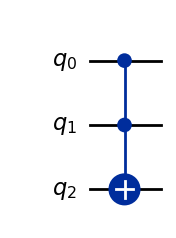

Input |0>  ->  Output {np.str_('000'): np.complex128(1+0j)}
Input |1>  ->  Output {np.str_('010'): np.complex128(1+0j)}
Input |2>  ->  Output {np.str_('001'): np.complex128(1+0j)}
Input |3>  ->  Output {np.str_('111'): np.complex128(1+0j)}


In [5]:
O = oracle(3)  # Test with any number
display(O.draw('mpl'))

# generate 3 qubit states initialized to |x>|0>
states = [Statevector.from_int(i, 2**3) for i in range(4)]
# we swap these to get the correct order when reading the Qiskit register (right to left)
states[1], states[2] = states[2], states[1]

for x in range(4):
    output_state = states[x].evolve(O) # Apply the oracle
    print(f'Input |{x}>  ->  Output {output_state.to_dict(3)}')

Does this look correct? Remember that Qiskit lists qubits from right to left, so for example '110' means that the data register is in state $|01\rangle$ and the workspace register is in state $|1\rangle$.

## Phase flip

The phase flip $\mathcal P$ acts only on the data register and satisfies  
$\mathcal P |0\rangle|q\rangle = |0\rangle|q\rangle$  
$\mathcal P |x\rangle|q\rangle = -|x\rangle|q\rangle$ if $x>0$.

<span style="color:red">Implement the function ``phase_flip`` which outputs a quantum circuit for the phase flip.</span>

In [27]:
"""
This function gives a circuit which flips phase only if the data register is not |00>.

Returns:
    QuantumCircuit on 3 qubits (2 for search register, 1 for oracle workspace)
    which implements the phase flip.
"""
def phase_flip():
    circ = QuantumCircuit(3, name='Phase')
    # Fill your gates here
    circ.x([0, 1])
    # circ.z([0, 1])
    circ.cz(0, 1)
    circ.x([0, 1])

    # circ.x([0, 1])
    # circ.ccx(0, 1, 2)
    # circ.x([0, 1])
   # circ.z([0, 1])
    #circ.ccx(0, 1, 2)
    #circ.cz(2, 1)
    #circ.ccx(0, 1, 2)
    # Finally return the phase flip circuit
    return circ

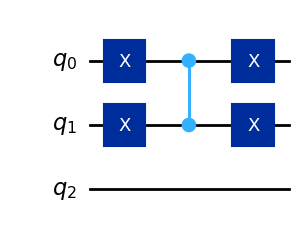

Input |0>  ->  Output {np.str_('000'): np.complex128(-1+0j)}
Input |1>  ->  Output {np.str_('010'): np.complex128(1+0j)}
Input |2>  ->  Output {np.str_('001'): np.complex128(1+0j)}
Input |3>  ->  Output {np.str_('011'): np.complex128(1+0j)}


In [28]:
P = phase_flip()
display(P.draw('mpl'))
for x in range(4):
    output_state = states[x].evolve(P)          # Apply the phase flip
    print(f'Input |{x}>  ->  Output {output_state.to_dict(3)}')

## Grover operator

Now that we have implemented the oracle and the phase flip, we can use them to build the complete Grover operator.

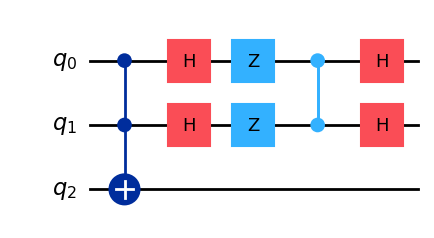

In [19]:
G = oracle(3)      # This chooses which element we search for
G.h([0, 1])
G = G.compose(phase_flip())
G.h([0, 1])
G.draw('mpl')

## Quantum search

Now the final step is to figure out how many times we need to apply the Grover operator in order to get the right answer.

<span style="color:red">Calculate how many times $R$ the Grover iteration has to be applied and fill it in the cell below.</span>

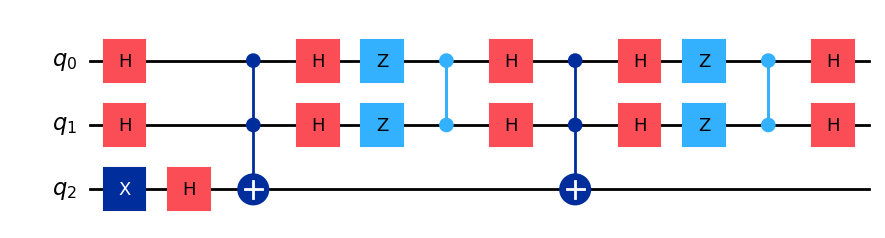

In [22]:
import math
num_solutions = 1
num_qubits = G.num_qubits - 1
R = math.floor(math.pi / (4 * math.asin(math.sqrt(num_solutions / 2**num_qubits)))) # Add here how many times to repeat the Grover operator
# This builds the completed circuit
R=2
circ = QuantumCircuit(3)
circ.h([0, 1])
circ.x(2)
circ.h(2)
for _ in range(R):
    circ = circ.compose(G)
circ.draw('mpl')

## Run the circuit

Now we test that the Grover search works.

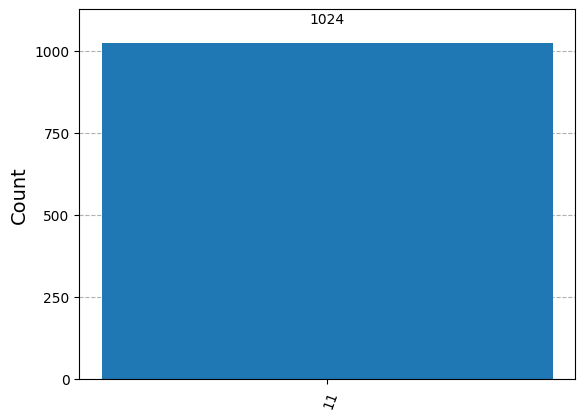

In [21]:
state = Statevector.from_int(0, 2**3)
state = state.evolve(circ)

# Measure the first two qubits:
counts = state.sample_counts(1024, qargs=[0,1])
plot_histogram(counts)

You should see that measurement matches your $x_0$.